## Libraries Import

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import warnings
import urllib.request
import json
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from random import randint
from matplotlib import rcParams
from pylab import *
from scipy.interpolate import make_interp_spline, BSpline, interp1d
from scipy.io import loadmat

## Load Data Function

In [3]:
def load_data(start_year, end_year, parameter):
    year = start_year - 1
    size = (end_year - start_year + 1) * 12
    month = 1
    x = [[]for i in range (size)]
    for i in range(0, size):
        year = year + 1 if ((i + 1) % 12) == 1 else year
        ms = '0' + str(month) if month<10 else str(month)
        filename = 'v' + parameter + str(year) + ms + '01' + '.txt'
        path = path = '~/Documents/Tesis/Data/' + parameter + '/' + str(year) + '/'
        x[i] = pd.read_csv(path + filename, header=None)
        month = month + 1 if month < 12 else 1
    return x

## Get Latitude and Longitude Functions

In [4]:
def findItem(theList, item):
    pos_list = [[ind, theList[ind].index(item)] for ind in range(len(theList)) if item in theList[ind]]
    return [pos_list[0][0], pos_list[0][1]]

def find_step(start, end, abs_step):
    act_step = abs(abs_step) if start < end else -abs(abs_step)
    return act_step

def create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step):
    lat = np.arange(start_lat, end_lat + lat_step, lat_step).tolist()
    lon = np.arange(start_lon, end_lon + lon_step, lon_step).tolist()
    grid = [[[]for i in range(len(lon))] for j in range(len(lat))]
    y = 0
    for i in range(0, len(lat)):
        for j in range(0, len(lon)):
            grid[i][j] = y
            y += 1
    return grid, lat, lon

def get_ll(index, grid, lat_list, lon_list):
    return lat_list[findItem(grid, index)[0]], lon_list[findItem(grid, index)[1]]

def get_index(latitude, longitude, grid, lat_list, lon_list):
    longitude = longitude + 360 if longitude < 0 else longitude
    return grid[lat_list.index(latitude)][lon_list.index(longitude)]

# print(get_ll(619683))
# print(get_index(-30.75,14))

## Get Elevation Function

In [124]:
def get_elevation(lat, lon):
    key = 'Ai9NLeGblweg0P_Br_bKnbLVkkRgbG6RlH4k5FrbBctSqD32KHMuFQmRyX-apadI'
    url = 'https://dev.virtualearth.net/REST/v1/Elevation/List?key=' + key + '&points=' + str(lat) + ',' + str(lon)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read().decode())
    elevation = data['resourceSets'][0]['resources'][0]['elevations'][0]
    return elevation, elevation / 1000

## ARIMA Function

In [6]:
def arima_model(data, numpr):
    X = data
    actual_size = len(data)
    train_size = int(0.75*len(data))
    train = X[0:train_size]
    test = X[train_size - 1:]
    
    best_aic = 99999
    p=(3,4,6)
    # p=range(1,6)
    d=range(0,1)
    q=range(1,5)
    pdq = list(itertools.product(p, d, q))
    
    warnings.filterwarnings('ignore')
    for param in pdq:
        try:
            model_arima = ARIMA(train, order = param)
            model_arima_fit = model_arima.fit()
            aic = model_arima_fit.aic
            print(param, aic)
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_fit = model_arima_fit
        except:
            continue
    
    model_arima = ARIMA(train, order=best_pdq)
    # model_arima_fit = model_arima.fit()
    aic = best_fit.aic
    predictions = best_fit.forecast(steps=(actual_size - train_size + 1 + numpr))[0]
    mse = mean_squared_error(test, predictions[0:len(test)])
    return predictions, train, test, aic, mse, best_pdq

## Data Loading

In [7]:
start_time = time.time()
tcwv_data = load_data(1979, 2019, 'tcwv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 202.75698256492615 seconds ---


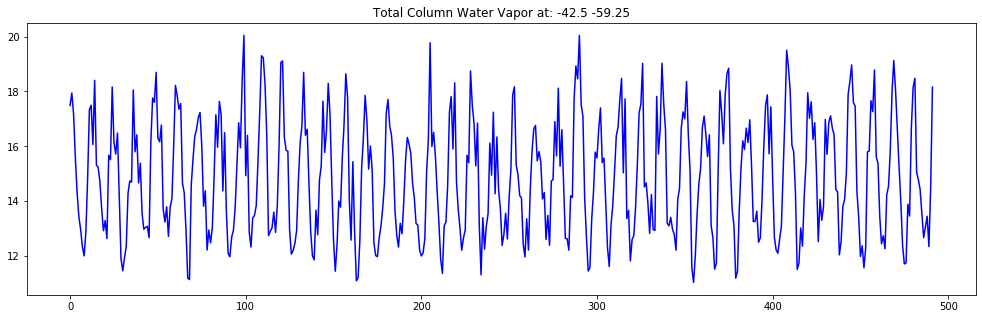

In [8]:
tcwv_values = [0] * (len(tcwv_data))
pos = randint(0, 1038239)
for i in range(len(tcwv_data)):
    tcwv_values[i] = tcwv_data[i][0].values[pos]

start_lat = 90
end_lat = -90
start_lon = 0
end_lon = 359.75
step = 0.25
lat_step = find_step(start_lat, end_lat, step)
lon_step = find_step(start_lon, end_lon, step)
    
lists = create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step)
grid_list = lists[0]
lat_list = lists[1]
lon_list = lists[2]
rcParams['figure.figsize'] = 17, 5

plt.plot(tcwv_values, 'b')
latstr = str(get_ll(pos, grid_list, lat_list, lon_list)[0])
lonstr = str(get_ll(pos, grid_list, lat_list, lon_list)[1] - 180)
# print('At position:', latstr, lonstr)
title = 'Total Column Water Vapor at: ' + latstr + ' ' + lonstr
plt.title(title)
# plt.savefig('figure.png')
plt.show()

(3, 0, 2) 1062.5306127667693
(3, 0, 3) 1069.2383983614777
(3, 0, 4) 1066.826173463243
(4, 0, 1) 1159.4383972058072
(4, 0, 2) 1061.9424625164486
(4, 0, 3) 1066.4703816053077
(4, 0, 4) 1065.0857327206759
(6, 0, 1) 1144.412879366084
(6, 0, 2) 1065.8051276165936
(6, 0, 3) 1067.7321561503963
(6, 0, 4) 1099.941176770766


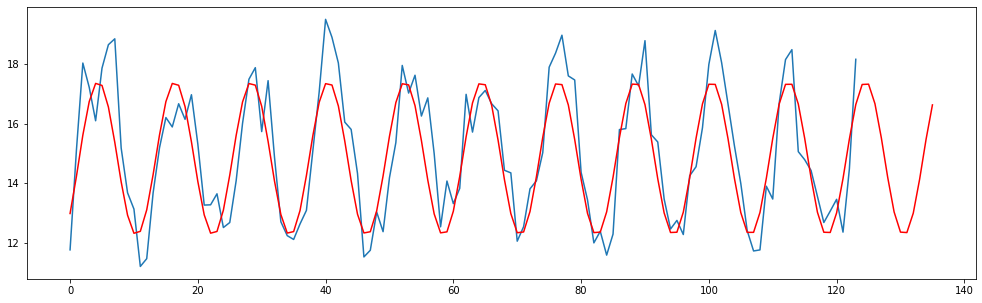

P, D, Q (4, 0, 2)
AIC: 1061.9424625164486
MSE: 1.2787686360708006


In [9]:
arima_func = arima_model(tcwv_values, 12)
predictions = arima_func[0]
train = arima_func[1]
test = arima_func[2]
aic = arima_func[3]
mse = arima_func[4]
best_pdq = arima_func[5]
str_i = 'AIC: ' + str(aic) + '\nMSE: ' + str(mse)

plt.plot(test)
plt.plot(predictions, 'r')
plt.show()

print('P, D, Q', best_pdq)
print(str_i)

In [10]:
def find_lat(lat_list, any_lat, step):
    lat = min(lat_list, key=lambda x: abs(x - any_lat))
    if any_lat - lat < 0:
        lat_t = lat
        lat_b = lat - step
    else:
        lat_t = lat + step
        lat_b = lat
    return lat_b, lat_t

def find_lon(lon_list, any_lon, step):
    any_lon = any_lon + 360 if any_lon < 0 else any_lon
    lon = min(lon_list, key=lambda x: abs(x - any_lon))
    if any_lon - lon < 0:
        lon_r = lon
        lon_l = lon - step
    else:
        lon_r = lon + step
        lon_l = lon
    lon_l_a = lon_l if lon_l < 180 else lon_l - 360
    lon_r_a = lon_r if lon_r < 180 else lon_r - 360
    return lon_l, lon_r, lon_l_a, lon_r_a
'''
cv_lat = find_lat(lat_list, 17.36, step)
cv_lon = find_lon(lon_list, -61.29, step)
print('Bottom Latitude', cv_lat[0], 'Top Latitude', cv_lat[1])
print('Left Longitude', cv_lon[2], 'Right Longitude', cv_lon[3])
'''

"\ncv_lat = find_lat(lat_list, 17.36, step)\ncv_lon = find_lon(lon_list, -61.29, step)\nprint('Bottom Latitude', cv_lat[0], 'Top Latitude', cv_lat[1])\nprint('Left Longitude', cv_lon[2], 'Right Longitude', cv_lon[3])\n"

In [11]:
def interp(lat, lon, month, year, parameter, grid, lat_list, lon_list, step):
    ms = '0' + str(month) if month<10 else str(month)
    filename = 'v' + parameter + str(year) + ms + '01' + '.txt'
    path = path = '~/Documents/Tesis/Data/' + parameter + '/' + str(year) + '/'
    data = pd.read_csv(path + filename, header=None)
    if (lat % 0.25) == 0 and (lon % 0.25) == 0:
        pos = get_index(lat, lon, grid, lat_list, lon_list)
        return data[0].values[pos]
    else:
        cv_lat = find_lat(lat_list, lat, step)
        cv_lon = find_lon(lon_list, lon, step)
        lat_0 = cv_lat[0]
        lat_1 = cv_lat[1]
        lon_a = cv_lon[2]
        lon_b = cv_lon[3]
        tl = get_index(lat_1, lon_a, grid, lat_list, lon_list)
        tr = tl + 1# get_index(lat_1, lon_b, grid, lat_list, lon_list)
        bl = tl + 1440# get_index(lat_0, lon_a, grid, lat_list, lon_list)
        br = bl + 1# get_index(lat_0, lon_b, grid, lat_list, lon_list)
        t = (lat - lat_0) / (lat_1 - lat_0)
        s = (lon - lon_a) / (lon_b - lon_a)
        X_tl = data[0].values[tl]
        X_tr = data[0].values[tr]
        X_bl = data[0].values[bl]
        X_br = data[0].values[br]
        value = (1 - s) * (1 - t) * X_bl + (1 - s) * t * X_tl + s * (1 - t) * X_br + t * s * X_tr
        # print([lat_1, lon_a + 180], [lat_1, lon_b + 180], '\n', [lat_0, lon_a + 180], [lat_0, lon_b + 180])
        # print('', round(X_tl, 4), round(X_tr, 4), '\n', round(X_bl, 4), round(X_br, 4))
        # print([lat_1, lon_a], [lat_1, lon_b], '\n', [lat_0, lon_a], [lat_0, lon_b])
        # print(tl, tr, '\n', bl, br)
        return value       

# interp(-17.35, -98.69, 1, 1985, 'tcwv', grid_list, lat_list, lon_list, step)
interp(-16.51, -68.17, 9, 1985, 'tcwv', grid_list, lat_list, lon_list, step)

8.031193695699994

In [59]:
def timeseries(sy, ey, lat, lon):
    c = 0
    aux_val = [0] * (ey - sy + 1) * 12
    aux_time = [0] * (ey - sy + 1) * 12
    for i in range(sy, ey + 1):
        for j in range(1, 13):
            aux_val[c] = interp(lat, lon, j, i, 'tcwv', grid_list, lat_list, lon_list, step)
            aux_time[c] = str(i) + '-' + ('0' + str(j) if j<10 else str(j)) + '-' + '01'
            c += 1
    return aux_val, aux_time

In [56]:
result = timeseries(1979,2019, -16.51, -68.17)
tcwv_p = result[0]
tcwv_t = result[1]

In [2]:
def savelist(array, name='file'):
    name = name + '.txt'
    with open(name, "w") as f:
        for s in array:
            f.write(str(s) +"\n")
def loadlist(array, name='file'):
    name = name + '.txt'
    with open(name, "r") as f:
        for line in f:
            array.append(float(line.strip()))

In [68]:
# savelist(tcwv_p, 'TCWV16.51S68.17W')
tcwv_p = []
loadlist(tcwv_p, 'TCWV16.51S68.17W')

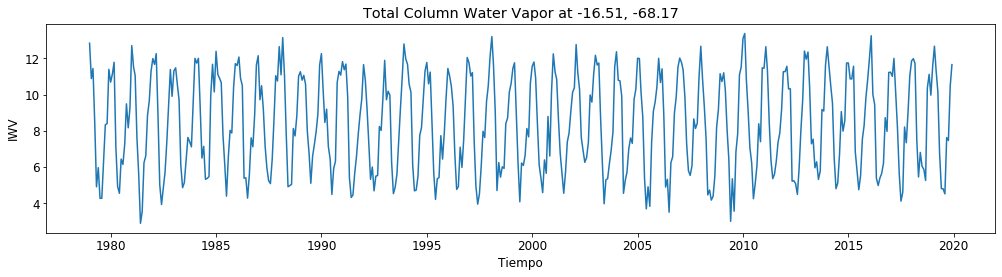

In [77]:
tcwv_p = np.array(tcwv_p)
tcwv_t = pd.to_datetime(tcwv_t)
rcParams['figure.figsize'] = 17, 5
rcParams['font.size'] = 12

DF = pd.DataFrame()
DF['IWV'] = tcwv_p
DF = DF.set_index(tcwv_t)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.3)
plt.xticks(rotation=0)
plt.plot(DF)
plt.title('Total Column Water Vapor at -16.51, -68.17')
plt.ylabel('IWV')
plt.xlabel('Tiempo')
plt.show()

In [135]:
def plothist(array, title, xmin, xmax, ymin=0, ymax=0, nb=10):
    hist, bin_edges = np.histogram(array, bins = nb)
    bin_edges = np.round(bin_edges,0)
    plt.bar(bin_edges[:-1], hist, width = 0.8, color='#0504aa',alpha=0.7)
    # plt.xlim(min(bin_edges)-1, max(bin_edges)+1)
    if ymax != 0:
        plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('IWV (mm)',fontsize=15)
    plt.ylabel('Porcentaje (%)',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

## Total Histogram

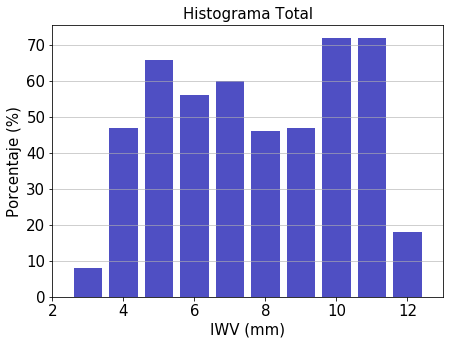

In [136]:
plothist(tcwv_p, 'Histograma Total', 2, 13)

In [20]:
# Seasons
# Summer January February March
# Autumn April May June
# Winter July August September
# Spring October November December
def ex_season(array, start, end):
    pos = 0
    c = 0
    y = int((len(array)/12))
    aux = [0] * (end - start + 1) * y
    for i in range(0,y):
        for j in range(start,end + 1):
            aux[c] = array[pos + j]
            # print(str(pos + j) + '|' + str(c))
            c += 1
        pos += 12
    return aux

In [21]:
summertcwv = ex_season(tcwv_p, 0, 2)
autumntcwv = ex_season(tcwv_p, 3, 5)
wintertcwv = ex_season(tcwv_p, 6, 8)
springtcwv = ex_season(tcwv_p, 9, 11)

## Summer
Este es el histograma de Verano de 1979 a 2019

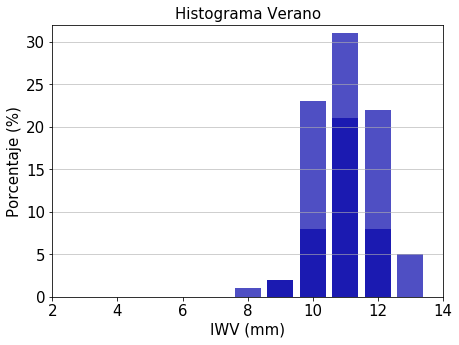

In [137]:
plothist(summertcwv, 'Histograma Verano',2 , 14, 0, 32)

## Autumn

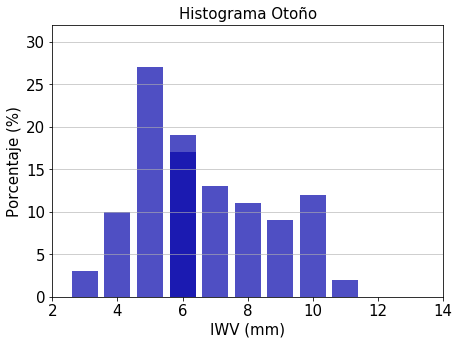

In [138]:
plothist(autumntcwv, 'Histograma Otoño',2 , 14, 0, 32)

# Winter

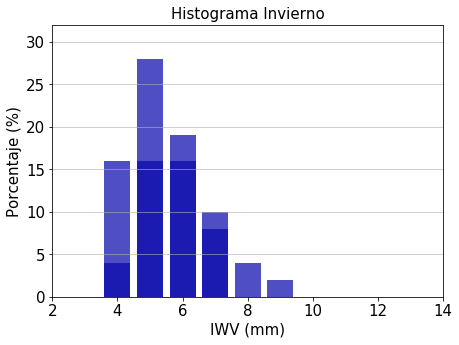

In [139]:
plothist(wintertcwv, 'Histograma Invierno',2 , 14, 0, 32)

## Spring

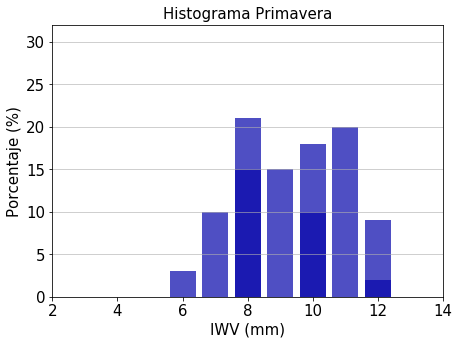

In [140]:
plothist(springtcwv, 'Histograma Primavera',2 , 14, 0, 32)

## CDF

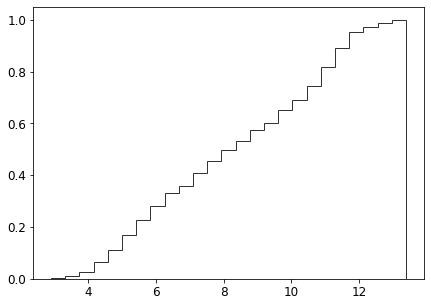

In [97]:
n = plt.hist(tcwv_p, bins=25, density=True, cumulative=True, log=False, label='CDF', histtype='step', alpha=0.8, color='k')

In [98]:
X = np.delete(n[1], -1)
cdf_Y = n[0]
ccdf_Y = 1-n[0]
print(len(X),len(cdf_Y), len(ccdf_Y))

25 25 25


In [146]:
print(X)
print(cdf_Y)

[ 2.90703526  3.32588148  3.7447277   4.16357392  4.58242014  5.00126636
  5.42011258  5.8389588   6.25780502  6.67665124  7.09549746  7.51434368
  7.9331899   8.35203612  8.77088234  9.18972856  9.60857478 10.027421
 10.44626722 10.86511344 11.28395966 11.70280588 12.1216521  12.54049832
 12.95934454]
[0.00406504 0.01219512 0.02439024 0.06300813 0.11178862 0.17073171
 0.22560976 0.2804878  0.33333333 0.3597561  0.41056911 0.45325203
 0.49796748 0.53252033 0.57520325 0.60365854 0.6504065  0.69105691
 0.74390244 0.81707317 0.89227642 0.95325203 0.97154472 0.9898374
 1.        ]


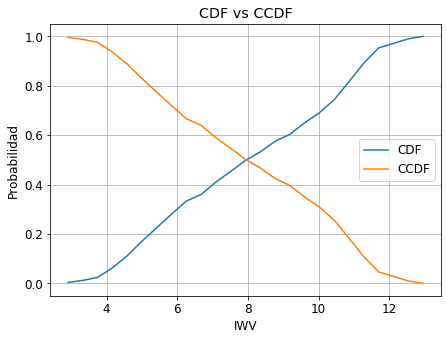

In [99]:
rcParams['figure.figsize'] = 7, 5
plt.grid(True, which="both")
plt.plot(X, cdf_Y, label='CDF')
plt.plot(X, ccdf_Y, label='CCDF')
plt.legend(loc='upper mid')
plt.xlabel('IWV')
plt.ylabel('Probabilidad')
plt.title('CDF vs CCDF')
plt.show()

## Smoothing the plot

In [42]:
def smplot(X, Y, p = 300):
    X = np.array(X)
    Y = np.array(Y)
    newx = np.linspace(X.min(), X.max(), 300)
    spl = make_interp_spline(X, Y, k=3)
    smoothy = spl(newx)
    return newx, smoothy

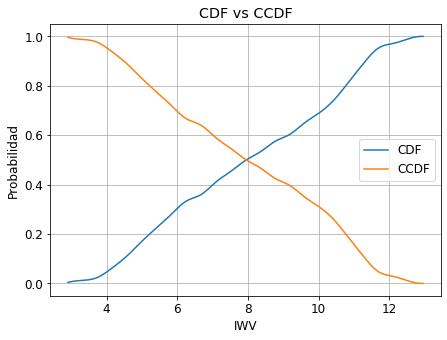

In [100]:
sm = smplot(X, cdf_Y)
sm_X = sm[0]
sm_cdf_Y = sm[1]
sm_ccdf_Y = smplot(X, ccdf_Y)[1]
rcParams['figure.figsize'] = 7, 5
plt.grid(True, which="both")
plt.plot(sm_X, sm_cdf_Y, label='CDF')
plt.plot(sm_X, sm_ccdf_Y, label='CCDF')
plt.legend(loc='upper mid')
plt.xlabel('IWV')
plt.ylabel('Probabilidad')
plt.title('CDF vs CCDF')
plt.show()

In [9]:
daily_tcwv_12 = []
loadlist(daily_tcwv_12, 'TCWV_Daily_12')
daily_tcwv_12 = np.array(daily_tcwv_12)

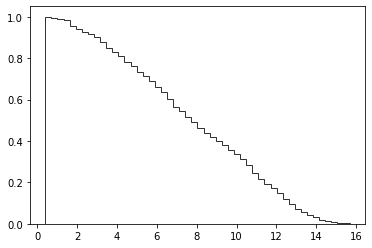

In [54]:
n = plt.hist(daily_tcwv_12, bins=50, density=True, cumulative=-1, log=False, label='CDF', histtype='step', alpha=0.8, color='k')

In [55]:
X = n[1]
ccdf_Y = np.append(n[0]*100,0)
print(len(X), len(ccdf_Y))

51 51


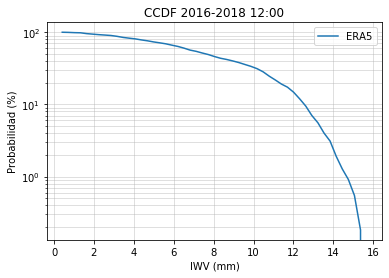

In [60]:
plt.grid(True, which="both", alpha=0.5)
#plt.semilogy(X, cdf_Y, label='CDF')
plt.semilogy(X, ccdf_Y, label='ERA5')
#plt.ylim(1e-1,1.2e2)
plt.legend(loc='best')
plt.xlabel('IWV (mm)')
plt.ylabel('Probabilidad (%)')
plt.title('CCDF 2016-2018 12:00')
plt.show()

In [95]:
def extract_data(var, file):
    size = len(file[var])
    out = [0] * size
    for i in range(size):
        out[i] = file[var][i][0]
    return np.array(out)

In [97]:
def itu676(f, p, T, rho):
    # p: dry air presure (hPa)
    # e: water vaour partial pressure (hPa)
    # theta (Θ): 300/T
    # T: Temperature
    # Spectroscopic Parameters
    wat_file = loadmat('Matlab/wat676.mat')
    oxy_file = loadmat('Matlab/oxy676.mat')
    fw = extract_data('fw', wat_file)
    b1 = extract_data('b1', wat_file)
    b2 = extract_data('b2', wat_file)
    b3 = extract_data('b3', wat_file)
    b4 = extract_data('b4', wat_file)
    b5 = extract_data('b5', wat_file)
    b6 = extract_data('b6', wat_file)
    fo = extract_data('fo', oxy_file)
    a1 = extract_data('a1', oxy_file)
    a2 = extract_data('a2', oxy_file)
    a3 = extract_data('a3', oxy_file)
    a4 = extract_data('a4', oxy_file)
    a5 = extract_data('a5', oxy_file)
    a6 = extract_data('a6', oxy_file)
    theta = 300/T
    # Equation (4)
    e = (rho*T)/216.7
    # Equation (3)
    So = a1 * (1e-7) * p * (theta**3) * np.exp(a2 * (1 - theta))
    Sw = b1 * (1e-1) * e * (theta**3.5) * np.exp(b2 * (1 - theta))
    # print(So) Ok
    # print(Sw) Ok
    # Equation (7)
    deltao = (a5 + a6 * theta) * (1e-4) * (p + e) * (theta**0.8)
    deltaw = 0
    # print(deltao) Ok
    # Equation (6a)
    deltafo_wd = a3 * (1e-4) * (p * (theta**(0.8 - a4)) + 1.1 * e * theta)
    deltafw_wd = b3 * (1e-4) * (p * (theta**b4) + b5 * e * (theta**b6))
    # print(deltafo_wd) Ok
    # print(deltafw_wd) Ok
    # Equation (6b)
    deltafo = np.sqrt(deltafo_wd**2 + 2.25e-6)
    deltafw = 0.535 * deltafw_wd + np.sqrt((0.217 * deltafw_wd**2) + (2.1316e-12 * (fw**2))/(theta))
    # print(deltafo) Ok
    # print(deltafw) Ok
    # Equation (5)
    Fo = ((f)/(fo)) * (((deltafo - deltao * (fo - f))/(deltafo**2 + (fo - f)**2))+((deltafo - deltao * (fo + f))/(deltafo**2 + (fo + f)**2)))
    Fw = ((f)/(fw)) * (((deltafw - deltaw * (fw - f))/(deltafw**2 + (fw - f)**2))+((deltafw - deltaw * (fw + f))/(deltafw**2 + (fw + f)**2)))
    # print(Fo) Ok
    # print(Fw) Ok
    # Equation 9
    d = (5.6e-4) * (p + e) * (theta**0.8)
    N2Df = f * p * theta**2 * (((6.14e-5)/(d * (1+(f/d)**2)))+((1.4e-12 * p * theta**1.5)/(1 + 1.9e-5 * f**1.5)))
    # print(d) Ok
    # print(N2Df) Ok
    N2f = sum(Fo * So) + sum(Fw * Sw) + N2Df
    # print(N2f) Ok
    y = 0.182 * f * N2f
    ywv = 0.182 * f * sum(Fw * Sw)
    yox = 0.182 * f * (sum(Fo * So) + N2Df)
    # print('y =', y)
    # print('ywv =', ywv)
    # print('yox =', yox)
    return y, ywv, yox

In [130]:
get_elevation(-17.51,-68.17)[1]

3.79

In [138]:
def calc_at(daily_tcwv, freq, lat=-16.51, lon=-68.17):
    daily_at = [np.empty(0), np.empty(0), np.empty(0), np.empty(0)]
    f_ref = 20.6
    p_ref = 845
    hs = get_elevation(lat,lon)[1]
    c = 0
    for f in freq:
        a = 0.2048 * exp(-((f-22.43)/(3.097))**2) + 0.2326 * exp(-((f-183.5)/(4.096))**2) + 0.2073 * exp(-((f-325)/(3.651))**2) - 0.1113
        b = 8.741e4 * exp(-0.587 * f) + 312.2 * f ** -2.38 + 0.723
        if hs < 0:
            h = 0
        elif hs >= 0 and hs < 4:
            h = hs
        else:
            h = 4
        # print(a)
        # print(b)
        for iwv in daily_tcwv_12:
            rho_vref = iwv / 2.38
            t_ref = 14 * np.log(0.22*iwv/2.38) + 3 + 273.15
            if f <= 20:
                a_w = (0.0176 * iwv * itu676(f, p_ref, t_ref, rho_vref)[1])/(itu676(f_ref, p_ref, t_ref, rho_vref)[1])
            else:
                a_w = (a * (h ** b) + 1)*(0.0176 * iwv * itu676(f, p_ref, t_ref, rho_vref)[1])/(itu676(f_ref, p_ref, t_ref, rho_vref)[1])
            daily_at[c] = np.append(daily_at[c], a_w)
        c += 1
    return daily_at

In [139]:
at = calc_at(daily_tcwv_12, [20, 40, 50, 75])

In [140]:
at_20 = at[0]
at_40 = at[1]
at_50 = at[2]
at_75 = at[3]

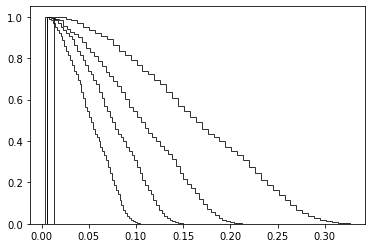

In [141]:
n1 = plt.hist(at_20, bins=50, density=True, cumulative=-1, log=False, label='CDF', histtype='step', alpha=0.8, color='k')
X_at20 = n1[1]
ccdf_Y_at20 = np.append(n1[0]*100,0)

n2 = plt.hist(at_40, bins=50, density=True, cumulative=-1, log=False, label='CDF', histtype='step', alpha=0.8, color='k')
X_at40 = n2[1]
ccdf_Y_at40 = np.append(n2[0]*100,0)

n3 = plt.hist(at_50, bins=50, density=True, cumulative=-1, log=False, label='CDF', histtype='step', alpha=0.8, color='k')
X_at50 = n3[1]
ccdf_Y_at50 = np.append(n3[0]*100,0)

n4 = plt.hist(at_75, bins=50, density=True, cumulative=-1, log=False, label='CDF', histtype='step', alpha=0.8, color='k')
X_at75 = n4[1]
ccdf_Y_at75 = np.append(n4[0]*100,0)

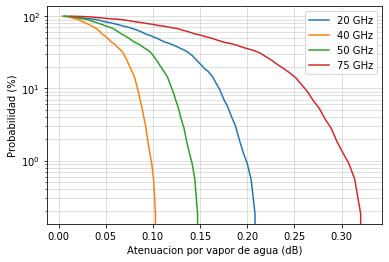

In [144]:
# Atenuacion Zenithal
#print(ccdf_Y_at20)
plt.grid(True, which="both", alpha=0.5)
#plt.semilogy(X, cdf_Y, label='CDF')
plt.semilogy(X_at20, ccdf_Y_at20, label='20 GHz')
plt.semilogy(X_at40, ccdf_Y_at40, label='40 GHz')
plt.semilogy(X_at50, ccdf_Y_at50, label='50 GHz')
plt.semilogy(X_at75, ccdf_Y_at75, label='75 GHz')
#plt.ylim(1e-1,1.2e2)
plt.legend(loc='best')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [146]:
prob_nom = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 60, 70, 80, 90, 95, 99]

In [148]:
print(ccdf_Y_at75)
print(X_at75)

[100.          99.6350365   98.99635036  98.26642336  96.80656934
  94.98175182  93.43065693  91.97080292  90.87591241  89.05109489
  86.31386861  83.57664234  81.38686131  79.10583942  76.82481752
  73.99635036  72.26277372  69.52554745  67.51824818  63.86861314
  60.58394161  56.93430657  54.5620438   51.55109489  49.08759124
  45.98540146  43.43065693  41.87956204  39.87226277  37.22627737
  35.31021898  33.39416058  30.93065693  27.46350365  24.45255474
  21.25912409  18.79562044  16.42335766  14.14233577  11.31386861
   9.03284672   6.75182482   5.2919708    3.74087591   2.82846715
   1.82481752   1.27737226   0.91240876   0.54744526   0.18248175
   0.        ]
[0.01288891 0.01915992 0.02543092 0.03170193 0.03797294 0.04424394
 0.05051495 0.05678595 0.06305696 0.06932797 0.07559897 0.08186998
 0.08814098 0.09441199 0.100683   0.106954   0.11322501 0.11949601
 0.12576702 0.13203803 0.13830903 0.14458004 0.15085105 0.15712205
 0.16339306 0.16966406 0.17593507 0.18220608 0.18847708 0

In [156]:
def interp_list(x, y, new_x):
    new_y = []
    y_interp = interp1d(x, y, kind='linear')
    new_y = np.array([float(y_interp(val)) for val in new_x])
    return new_y
new_at = (interp_list(ccdf_Y_at75, X_at75, prob_nom))
print(new_at)
print(prob_nom)

[0.3230027  0.3198672  0.31814895 0.31471243 0.30612116 0.29398961
 0.28763423 0.27745159 0.26107025 0.23557931 0.21524438 0.16107046
 0.13931239 0.11840904 0.09195376 0.06606704 0.04418123 0.02539509]
[0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 60, 70, 80, 90, 95, 99]


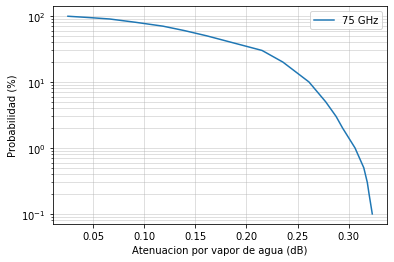

In [155]:
plt.semilogy(new_at, prob_nom, label='75 GHz')
#plt.ylim(1e-1,1.2e2)
plt.grid(True, which="both", alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()